In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

### ignore warnings ###
import warnings
warnings.filterwarnings("ignore")

### iteractive mode ###
plt.ion()

In [2]:
landmarks_frame = pd.read_csv("faces/face_landmarks.csv")
landmarks_frame.head()
landmarks_frame.shape
len(landmarks_frame)

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516


(69, 137)

69

In [3]:
n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n,1:].as_matrix()
landmarks = landmarks.astype(float).reshape(-1,2)
print("image_name:"+ str(img_name))
print("Landmark shape: {}".format(landmarks.shape) )
print("First 4 landmakrs: {}".format(landmarks[0:4]))

image_name:person-7.jpg
Landmark shape: (68, 2)
First 4 landmakrs: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


<Figure size 432x288 with 0 Axes>

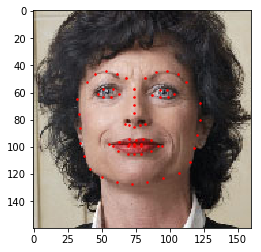

In [4]:
def show_landmarks(image,landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:,0], landmarks[:,1], s = 10, marker = ".", c = "r")
    ### pause a little bit before next figure appear ###
    plt.pause(0.001)
    
plt.figure()
show_landmarks(io.imread(os.path.join("faces/",img_name)), landmarks)
plt.show()


In [5]:
class FaceLandmarksDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform = None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self,idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx,0])
        img = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx,1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1,2)
        sample = {"image":img, "landmarks":landmarks}
        
        if self.transform:
            #print(self.transform)
            sample = self.transform(sample)
            
        return sample
        

0 (324, 215, 3) (68, 2)


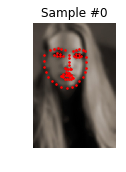

1 (500, 333, 3) (68, 2)


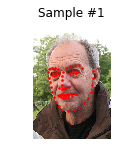

2 (250, 258, 3) (68, 2)


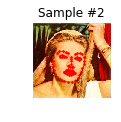

3 (434, 290, 3) (68, 2)


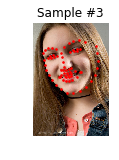

In [6]:
face_dataset = FaceLandmarksDataset("faces/face_landmarks.csv", "faces/")
fig = plt.figure()
for i in range(len(face_dataset)):
    sample = face_dataset[i]
    print(i, sample["image"].shape, sample["landmarks"].shape)
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    _= ax.set_title('Sample #{}'.format(i))
    _ = ax.axis('off')
    show_landmarks(**sample)
    if i == 3:
        _ = plt.show()
        break
    

### Transform (deal with the data with different sizes)

In [7]:
class Rescale(object):
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
            
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image, (new_h, new_w))
        landmarks = landmarks * [new_w/w, new_h/h]
        
        sample = {"image":img, "landmarks": landmarks}
        
        return sample

In [8]:
class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        ### return random integer between 0 to new_h-h ###
        top = np.random.randint(0, h-new_h)
        left = np.random.randint(0,w-new_w )
        image = image[top:top+new_h, left:left+new_w]
        landmarks = landmarks - [left, top]
        
        sample = {"image":image, "landmarks": landmarks}
        return sample

In [9]:
class ToTensor(object):
    def __call__(self, sample):
        image, landmarks = sample["image"], sample["landmarks"]
        # numpy image: H x W x C
        # torch image: C X H X W
        ### transpose --> first row become first column, is a function for numpy array####
        image = image.transpose((2,0,1))
        return {"image": torch.from_numpy(image), "landmarks": torch.from_numpy(landmarks)}

In [10]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([scale, RandomCrop(224)])

Text(0.5,1,'Rescale')

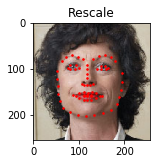

Text(0.5,1,'RandomCrop')

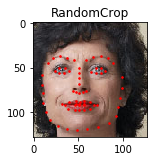

Text(0.5,1,'Compose')

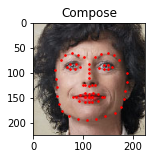

In [11]:
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    
    ax = plt.subplot(1,3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)
plt.show()

(0, 256)

(264, 0)

Text(0.5,1,'Rescale')

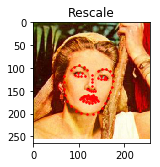

(0, 128)

(128, 0)

Text(0.5,1,'RandomCrop')

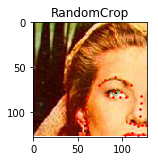

(0, 224)

(224, 0)

Text(0.5,1,'Compose')

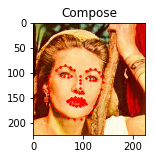

In [12]:
fig = plt.figure()
sample = face_dataset[2]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    
    ax = plt.subplot(1,3, i + 1)
    plt.tight_layout()
    plt.xlim(0, transformed_sample["image"].shape[0])
    plt.ylim(transformed_sample["image"].shape[1], 0)
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)
plt.show()

### Iterating through the dataset

In [13]:
transformed_dataset = FaceLandmarksDataset(csv_file="faces/face_landmarks.csv", 
                                           root_dir = "faces/",
                                           transform = transforms.Compose([Rescale(256), RandomCrop(224),
                                                                          ToTensor()]))

In [14]:
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    print(i, sample["image"].size(), sample["landmarks"].size())

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])
4 torch.Size([3, 224, 224]) torch.Size([68, 2])
5 torch.Size([3, 224, 224]) torch.Size([68, 2])
6 torch.Size([3, 224, 224]) torch.Size([68, 2])
7 torch.Size([3, 224, 224]) torch.Size([68, 2])
8 torch.Size([3, 224, 224]) torch.Size([68, 2])
9 torch.Size([3, 224, 224]) torch.Size([68, 2])
10 torch.Size([3, 224, 224]) torch.Size([68, 2])
11 torch.Size([3, 224, 224]) torch.Size([68, 2])
12 torch.Size([3, 224, 224]) torch.Size([68, 2])
13 torch.Size([3, 224, 224]) torch.Size([68, 2])
14 torch.Size([3, 224, 224]) torch.Size([68, 2])
15 torch.Size([3, 224, 224]) torch.Size([68, 2])
16 torch.Size([3, 224, 224]) torch.Size([68, 2])
17 torch.Size([3, 224, 224]) torch.Size([68, 2])
18 torch.Size([3, 224, 224]) torch.Size([68, 2])
19 torch.Size([3, 224, 224]) torch.Size([68, 2])
20 torch.Size([3, 224, 224]) t

In [15]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


<Figure size 432x288 with 0 Axes>

torch.Size([4, 3, 224, 224])


(-0.5, 905.5, 227.5, -15.874211690402348)

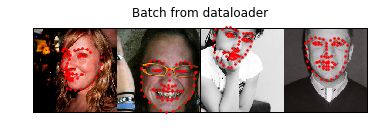

In [41]:
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched["image"], sample_batched["landmarks"]
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    print(images_batch.size())

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

### torchvision

In [16]:
import torch
from torchvision import transforms, datasets

In [17]:
data_transform  = transforms.Compose([
    transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [22]:
hymenoptera_dataset = datasets.ImageFolder(root = "hymenoptera_data/train", transform = data_transform)

In [25]:
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset, batch_size= 4, shuffle= True, num_workers=4)

In [38]:
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched[0], sample_batched[1]
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    print(images_batch.size())

    grid = utils.make_grid(images_batch)
    ### Tensor graph axis: C * H * W ###
    ### Transpose to numpy graph axis: H * W * C ###
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.title('Batch from dataloader')



0 torch.Size([4, 3, 224, 224]) torch.Size([4])
1 torch.Size([4, 3, 224, 224]) torch.Size([4])
2 torch.Size([4, 3, 224, 224]) torch.Size([4])
3 torch.Size([4, 3, 224, 224]) torch.Size([4])


<Figure size 432x288 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 224, 224])


(-0.5, 905.5, 227.5, -0.5)

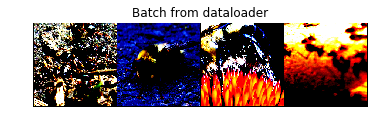

In [39]:
for i_batch, sample_batched in enumerate(dataset_loader):
    print(i_batch, sample_batched[0].size(),
          sample_batched[1].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

### Notes:

1. Know how to code the basic functions 
2. Use pytorch functions:transforms, ImageFolder, Dataloder, 
3. Remember the protocol: 1)determine transform; 2)second preprocessing data using transform; 3)third read data with batch, shuffle and num_workers
4. Numpy graph: H $*$ W $*$ C; Tensor graph: C $*$ H $*$ W                   